## Features' PSI Calculation and Ranking

In [21]:
import numpy as np
import pandas as pd

#PSI function Defining
#Calculate the PSI (population stability index) across all variables
def calculate_psi(initial, new, buckettype = 'quantiles', buckets = 10, axis = 1):

    #Calculate the PSI for a single variable
    def psi(initial_array, new_array, buckets):

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input
        
        # Breakpoints: Points value that separate the data into each bucket.
        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
        
        #Bins vs Quantiles Breakpoints
        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(initial_array), np.max(initial_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(initial_array, b) for b in breakpoints])

        initial_percents = np.histogram(initial_array, breakpoints)[0] / len(initial_array)
        new_percents = np.histogram(new_array, breakpoints)[0] / len(new_array)
        
        #Calculate the new's PSI value from comparing the values.
        #Update the new's value to a very small number if equal to zero
        def sub_psi(ini_perc, new_perc):
            if new_perc == 0:
                new_perc = 0.0001
            if ini_perc == 0:
                ini_perc = 0.0001

            value = (ini_perc - new_perc) * np.log(ini_perc / new_perc)
            return(value)

        psi_value = np.sum(sub_psi(initial_percents[i], new_percents[i]) for i in range(0, len(initial_percents)))

        return(psi_value)
    
    if len(initial.shape) == 1:
        psi_values = np.empty(len(initial.shape))
    else:
        psi_values = np.empty(initial.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(initial, new, buckets)
        elif axis == 0:
            psi_values[i] = psi(initial[:,i], new[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(initial[i,:], new[i,:], buckets)

    return(psi_values)


#Data Import
#--------------------------------------------------------------
Initial_Raw = pd.read_csv("C:/Users/USER/5. SCG/preML_v5b_010622.csv", dtype={"tax_id": str, "cust_name": str,"mind_sect": str, "input1_tax_id": str})
Initial_Raw_Drop = Initial_Raw[['liabilities_sum', 'unbilled_min', 'unbilled_median', 'co_use_mean','co_use_max',
                                'status_min','max_overdue_days','average_overdue_days','overdue_payments','total_payments',
                                'od_0_to_3_bucket', 'od_8_to_15_bucket', 'od_16_to_30_bucket', 'od_31_to_60_bucket',
                                'overdue_amount','max_overdue_amount','avg_by_date','Overdue_Amt_std','OD_total_credit_limit_max',
                                'OD_total_credit_limit_mean','OD_outstanding_max','OD_utilize_mean','OD_utilize_std']]

Initial_Raw_Drop = Initial_Raw_Drop.rename(columns = {'od_0_to_3_bucket':'0-3 Days Overdue', 'od_8_to_15_bucket':'8-15 Days Overdue',
                                   'od_16_to_30_bucket':'16-30 Days Overdue', 'od_31_to_60_bucket':'31-60 Days Overdue'})

New_Raw = pd.read_excel("C:/Users/USER/5. SCG/CREDIT_SCORING_0421_0322_input.xlsx", dtype={"mtaxno": str})
New_Raw_Drop = New_Raw.drop(columns = ['mtaxno'])
#print(Initial_Raw_Drop.shape)
#print(New_Raw_Drop.shape)
    
column_headers = list(Initial_Raw_Drop.columns.values)
#print("The Column Header :", column_headers)
Summary_PSI = [] 
Summary_Sample = []
a = 0
    
for i in column_headers:
    ## Condition, adjusting for the evenly distributed buckets
    if i == 'liabilities_sum' or 'unbilled_median':
        initial = Initial_Raw_Drop[[i]].dropna() #Drop NAN
        initial = initial.loc[~(initial==0).all(axis=1)].to_numpy() #Drop 0
        new = New_Raw_Drop[[i]].dropna() #Drop NAN
        new = new.loc[~(new==0).all(axis=1)].to_numpy() #Drop 0
    elif i == 'status_min' or 'co_use_mean' or 'co_use_max' or 'unbilled_min':
        initial = Initial_Raw_Drop[[i]].dropna() #Drop NAN
        initial = initial.loc[~(initial==0).all(axis=1)].to_numpy() #Drop 0
        new = New_Raw_Drop[[i]].dropna() #Drop NAN
        new = new.loc[~(new==0).all(axis=1)].to_numpy() #Drop 0
    elif i == 'co_use_max' or 'unbilled_min':
        initial = Initial_Raw_Drop[[i]].dropna() #Drop NAN
        initial = initial.loc[~(initial==0).all(axis=1)].to_numpy() #Drop 0
        new = New_Raw_Drop[[i]].dropna() #Drop NAN
        new = new.loc[~(new==0).all(axis=1)].to_numpy() #Drop 0
    else:
        initial = Initial_Raw_Drop[[i]].dropna().to_numpy() #Drop NAN
        new = New_Raw_Drop[[i]].dropna().to_numpy() #Drop NAN'''
    #initial = Initial_Raw_Drop[[i]].dropna().to_numpy() #Drop NAN
    #new = New_Raw_Drop[[i]].dropna().to_numpy() #Drop NAN 
        
    #Removing Mode of the feature, Not doing bc. that's the real value.
    '''if i == 'OD_total_credit_limit_mean' :
        initial = Initial_Raw_Drop[[i]].dropna()
        #print("vvv", initial.shape)
        initial = initial.loc[~(initial==0).all(axis=1)]
       # print("vvv", initial.shape)
        initial = initial.drop(initial[initial.OD_total_credit_limit_mean == 10000000].index).to_numpy()
        #print("vvv", initial.shape)
        new = New_Raw_Drop[[i]].dropna()
        new = new.loc[~(new==0).all(axis=1)]
        new = new.drop(new[new.OD_total_credit_limit_mean == 10000000].index).to_numpy()
        print("I'm OD_total_credit_limit_mean")
    
    elif i == '8-15 Days Overdue': 
        initial = Initial_Raw_Drop[[i]].dropna()
        initial = initial.loc[~(initial<=2).all(axis=1)].to_numpy()
        new = New_Raw_Drop[[i]].dropna()
        new = new.loc[~(new<=2).all(axis=1)].to_numpy()
        print("I'm 8-15 Days Overdue")
    
    # Removing NAN and 0 (Assuming it's a mode)
    else: #i == 'liabilities_sum'  or 'unbilled_min' or 'average_overdue_days' or 'OD_total_credit_limit_max' or 'OD_utilize_std':
        initial = Initial_Raw_Drop[[i]].dropna()
        initial = initial.loc[~(initial==0).all(axis=1)].to_numpy()
        new = New_Raw_Drop[[i]].dropna()
        new = new.loc[~(new==0).all(axis=1)].to_numpy()
        a = a+1
        print("I'm alternate", a)'''
        
    #Other normal features; Removing NAN only
    '''else:
        initial = Initial_Raw_Drop[[i]].dropna().to_numpy()
        new = New_Raw_Drop[[i]].dropna().to_numpy()
        print ("I'm normal")'''
    
    #CAL PSI
    #Breakpoints: Points value that separate the data into each bucket.
    buckets = 10
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

    breakpoints = np.stack([np.percentile(initial, b) for b in breakpoints])
        #breakpoints

    initial_counts = np.sum(initial <= breakpoints[1])

    for x in range(1, 9):
        initial_counts = np.append(initial_counts, np.sum((initial > breakpoints[x]) & (initial <= breakpoints[x+1]))) 

    initial_counts = np.append(initial_counts, np.sum(initial > breakpoints[9]))

    #initial_counts = np.histogram(initial, breakpoints)[0]
    new_counts = np.histogram(new, breakpoints)[0]
        #initial_counts

    df_quan = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})

    df_quan['Initial Percent'] = df_quan['Initial Count'] / len(initial)
    df_quan['New Percent'] = df_quan['New Count'] / len(new)
    df_quan['New Percent'][df_quan['New Percent'] == 0] = 0.001
    percents = df_quan[['Initial Percent', 'New Percent', 'Bucket']] \
                 .melt(id_vars=['Bucket']) \
                 .rename(columns={'variable':'Population', 'value':'Percent'})

    v = calculate_psi(initial, new, buckettype='quantiles', buckets=10, axis=1)
    
    Summary_PSI.append(v)
    Summary_Sample.append(len(initial))
    
#Summary_PSI   
Summary = pd.DataFrame({'Column': column_headers, 'PSI value': Summary_PSI, 'Sample': Summary_Sample})

#At the eand, add each psi of each column to the table

# create a list of our conditions
conditions = [
    (Summary['PSI value'] < 0.1),
    (Summary['PSI value'] >= 0.1) & (Summary['PSI value'] < 0.2),
    (Summary['PSI value'] >= 0.2)] # But if 0.25, there are no Significant change
values = ['No change', 'Slight change', 'Significant change']
Summary['Interpretation'] = np.select(conditions, values)

<ipython-input-21-33f8347c98d2>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quan['New Percent'][df_quan['New Percent'] == 0] = 0.001
<ipython-input-21-33f8347c98d2>:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_value = np.sum(sub_psi(initial_percents[i], new_percents[i]) for i in range(0, len(initial_percents)))
<ipython-input-21-33f8347c98d2>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quan['New Percent'][df_quan['New Percent'] == 0] = 0.001
<ipython-input-2

In [22]:
display(Summary)
print("There are", np.sum(Summary['Interpretation'] == 'No change'), "features remain unchanged")
print("There are", np.sum(Summary['Interpretation'] == 'Slight change'), "features require slight changes")
print("There are", np.sum(Summary['Interpretation'] == 'Significant change'), "features require significant changes")

,Column,PSI value,Sample,Interpretation
0,liabilities_sum,0.019323,902,No change
1,unbilled_min,0.128179,726,Slight change
2,unbilled_median,0.022883,856,No change
3,co_use_mean,0.024820,885,No change
4,co_use_max,0.017330,885,No change
5,status_min,0.036680,885,No change
6,max_overdue_days,0.082154,1132,No change
7,average_overdue_days,0.112848,1111,Slight change
8,overdue_payments,0.027561,1111,No change
9,total_payments,0.063030,1244,No change


There are 19 features remain unchanged
There are 3 features require slight changes
There are 1 features require significant changes


## Features' PSI Visualisation

<ipython-input-23-3aaa160f7701>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quan['New Percent'][df_quan['New Percent'] == 0] = 0.001
<ipython-input-23-3aaa160f7701>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quan['New Percent'][df_quan['New Percent'] == 0] = 0.001
<ipython-input-23-3aaa160f7701>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quan['New Percent'][df_quan['New Percent'] == 0] = 0.001
<ipython-inpu

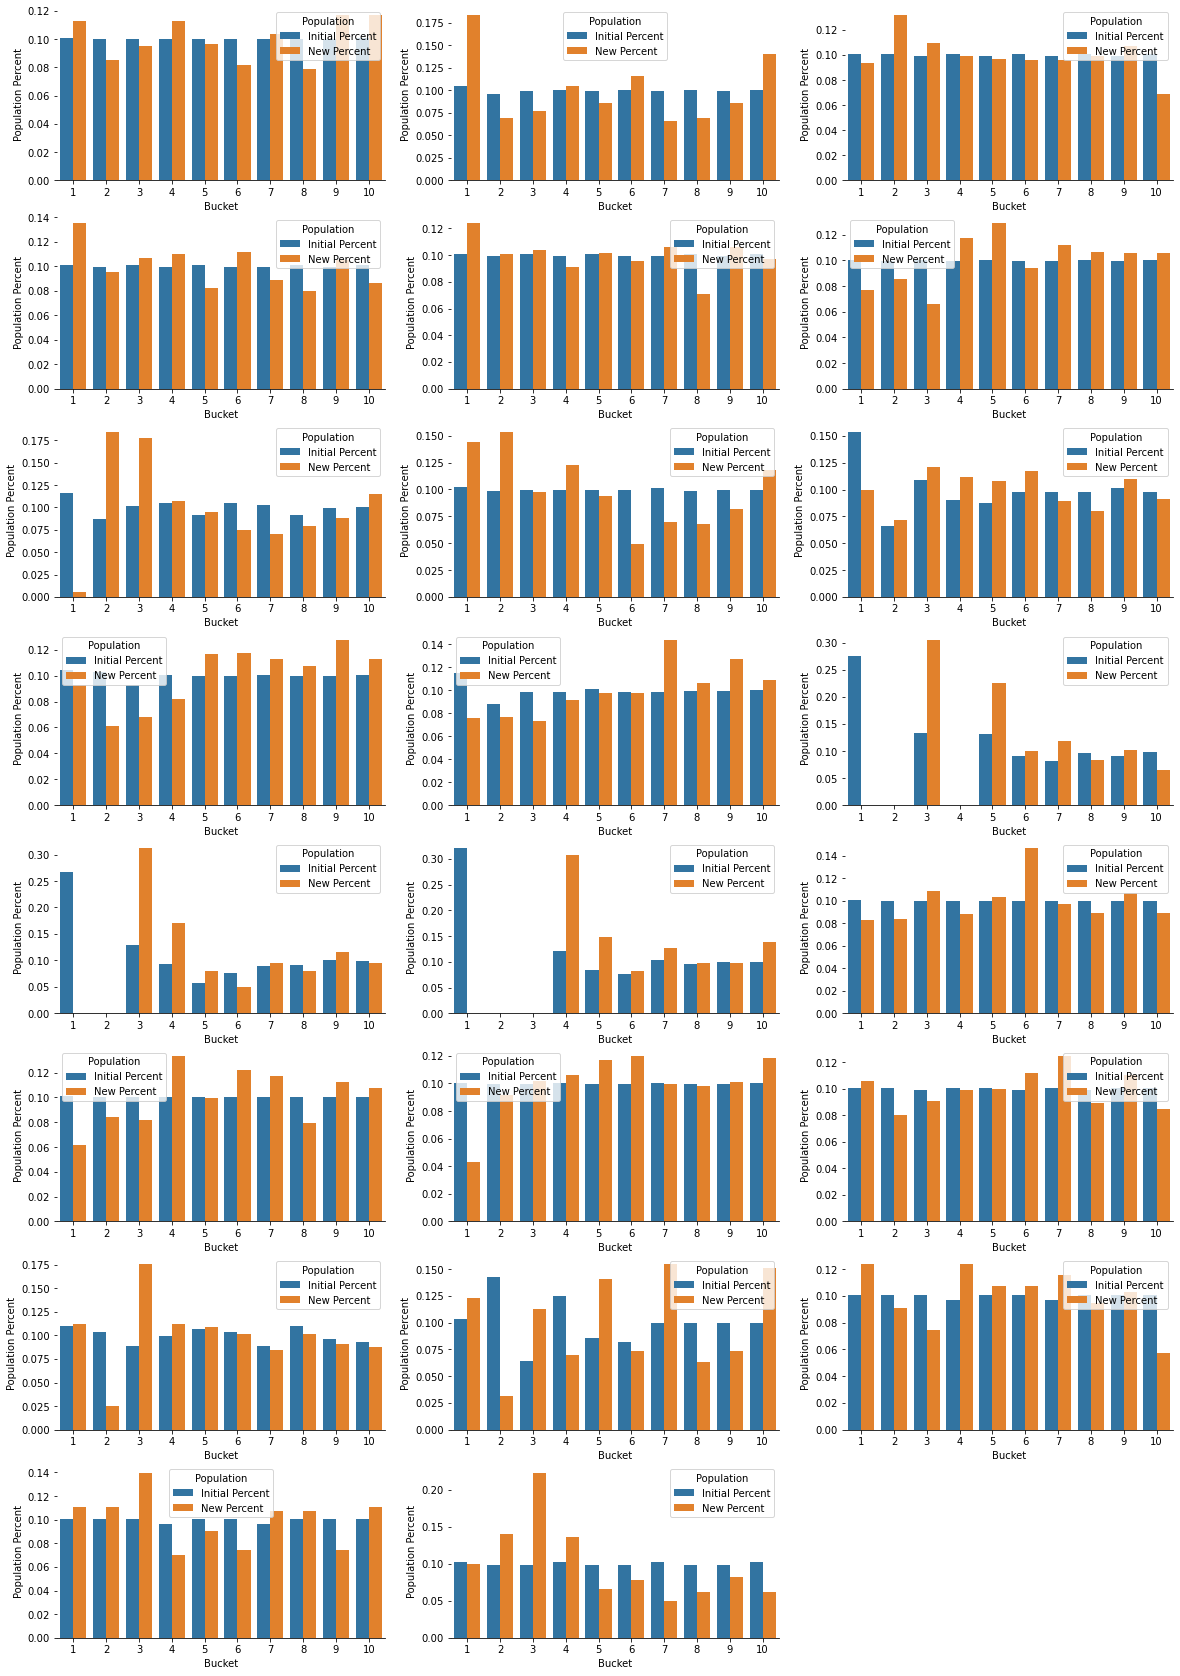

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20, 30))
for i in enumerate(column_headers):
    plt.subplot(8, 3,i[0]+1)
    
    ## Condition, adjusting for the evenly distributed buckets
    if i[1] == 'liabilities_sum' or 'unbilled_median':
        initial = Initial_Raw_Drop[[i[1]]].dropna() #Drop NAN
        initial = initial.loc[~(initial==0).all(axis=1)].to_numpy() #Drop 0
        new = New_Raw_Drop[[i[1]]].dropna() #Drop NAN
        new = new.loc[~(new==0).all(axis=1)].to_numpy() #Drop 0
    if i[1] == 'status_min' or 'co_use_mean' :
        initial = Initial_Raw_Drop[[i[1]]].dropna() #Drop NAN
        initial = initial.loc[~(initial==0).all(axis=1)].to_numpy() #Drop 0
        new = New_Raw_Drop[[i[1]]].dropna() #Drop NAN
        new = new.loc[~(new==0).all(axis=1)].to_numpy() #Drop 0
    if i[1] == 'co_use_max' or 'unbilled_min':
        initial = Initial_Raw_Drop[[i[1]]].dropna() #Drop NAN
        initial = initial.loc[~(initial==0).all(axis=1)].to_numpy() #Drop 0
        new = New_Raw_Drop[[i[1]]].dropna() #Drop NAN
        new = new.loc[~(new==0).all(axis=1)].to_numpy() #Drop 0
    else:
        initial = Initial_Raw_Drop[[i[1]]].dropna().to_numpy() #Drop NAN
        new = New_Raw_Drop[[i[1]]].dropna().to_numpy() #Drop NAN'''
    
    #initial = Initial_Raw_Drop[[i[1]]].dropna().to_numpy() #Drop NAN
    #new = New_Raw_Drop[[i[1]]].dropna().to_numpy() #Drop NAN
    
    #Removing Mode of the feature also
    '''if i[1] == 'OD_total_credit_limit_mean' :
        initial = Initial_Raw_Drop[[i[1]]].dropna()
        #print("vvv", initial.shape)
        initial = initial.loc[~(initial==0).all(axis=1)]
       # print("vvv", initial.shape)
        initial = initial.drop(initial[initial.OD_total_credit_limit_mean == 10000000].index).to_numpy()
        #print("vvv", initial.shape)
        new = New_Raw_Drop[[i[1]]].dropna()
        new = new.loc[~(new==0).all(axis=1)]
        new = new.drop(new[new.OD_total_credit_limit_mean == 10000000].index).to_numpy()
        
    # Removing NAN and 0 (Assuming it's a mode)
    else: #i == 'liabilities_sum'  or 'unbilled_min' or 'average_overdue_days' or 'OD_total_credit_limit_max' or 'OD_utilize_std':
        initial = Initial_Raw_Drop[[i[1]]].dropna()
        initial = initial.loc[~(initial==0).all(axis=1)].to_numpy()
        new = New_Raw_Drop[[i[1]]].dropna()
        new = new.loc[~(new==0).all(axis=1)].to_numpy()
        a = a+1
    #Other normal features; Removing NAN only'''
    
    #CAL PSI
    #Breakpoints: Points value that separate the data into each bucket.
    buckets = 10
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

    breakpoints = np.stack([np.percentile(initial, b) for b in breakpoints])
        #breakpoints

    initial_counts = np.sum(initial <= breakpoints[1])

    for x in range(1, 9):
        initial_counts = np.append(initial_counts, np.sum((initial > breakpoints[x]) & (initial <= breakpoints[x+1]))) 

    initial_counts = np.append(initial_counts, np.sum(initial > breakpoints[9]))

    #initial_counts = np.histogram(initial, breakpoints)[0]
    new_counts = np.histogram(new, breakpoints)[0]
        #initial_counts

    df_quan = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})

    df_quan['Initial Percent'] = df_quan['Initial Count'] / len(initial)
    df_quan['New Percent'] = df_quan['New Count'] / len(new)
    df_quan['New Percent'][df_quan['New Percent'] == 0] = 0.001
    percents = df_quan[['Initial Percent', 'New Percent', 'Bucket']] \
                 .melt(id_vars=['Bucket']) \
                 .rename(columns={'variable':'Population', 'value':'Percent'})
    
    sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents).set(xlabel='Bucket', ylabel='Population Percent')
    sns.despine(left=True)
plt.savefig('PSI.png')